In this project, we explore link prediction in a heterogeneous graph consisting of documents like datasets, publications, scientific keywords, platforms, and 

projects. We compare two methods: a Graph Neural Network (GCN) with a link prediction head and a Random Walk approach using Personalized PageRank (PPR). Our goal is

to understand how well each model predicts the likelihood of edges (relationships) between nodes

In [1]:
#import libraries 
import pandas as pd
import numpy as np
import random
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv, will use this if GCNcov does not perform well
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, average_precision_score

c:\Users\yhung\Desktop\Career Path\Msc. Computer Science\Semester two\Advanced ML\Assignment 1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# stored in a different cell for emphasis, the randomwalk algorithm is in random_walk.py 
from random_walk import RandomWalkLinkPrediction #stored in different file for readability


The dataset is composed of four files: one containing nodes and three representing edges (train, validation, test). 

Each node has an ID, a label (e.g., 'dataset', 'publication'), and descriptive properties in textual format. Edges describe relationships such as "uses dataset" or 

"has scientific keyword". To perform link prediction, we convert this into a PyG-compatible graph structure.

In [2]:
# Step 1: Load the data
def load_data(nodes_file, train_edges_file, valid_file, test_file):
    # Load nodes and their properties
    nodes_df = pd.read_csv(nodes_file)
    train_edges_df = pd.read_csv(train_edges_file)
    valid_df = pd.read_csv(valid_file)
    test_df = pd.read_csv(test_file)
    
    return nodes_df, train_edges_df, valid_df, test_df

In [3]:
nodes_file = "Dataset/nodes.csv"
train_edges_file = "Dataset/train_edges.csv"
valid_file = "Dataset/val_links.csv"
test_file = "Dataset/test_links.csv"

nodes_df, train_edges_df, valid_df, test_df = load_data(nodes_file, train_edges_file, valid_file, test_file)

print(f"{nodes_df.head()}\n\ntrain Edges\n\n {train_edges_df.head()}\n\nValidation edges\n\n {valid_df.head()}\n\ntest Edges\n\n {test_df.head()}")

   id        label                                         properties
0   0  ['Dataset']  {'abstract': 'The Atmospheric Infrared Sounder...
1   1  ['Dataset']  {'abstract': 'Version 07 is the current versio...
2   2  ['Dataset']  {'abstract': 'The Solar Backscattered Ultravio...
3   3  ['Dataset']  {'abstract': 'The data presented in this level...
4   4  ['Dataset']  {'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...

train Edges

    source  target   relationship_type
0    1152    1354          OF_PROJECT
1    1317    1164         HAS_DATASET
2    1317     768         HAS_DATASET
3    1271   23795  HAS_SCIENCEKEYWORD
4     820   23837  HAS_SCIENCEKEYWORD

Validation edges

    source  target
0    1144   23689
1    1016   23689
2    1298   24881
3     348   23780
4     876   23715

test Edges

    source  target
0     545   24190
1     867   24623
2     962   23690
3     857   23715
4     242   23819


This function is used to process the nodes, by creating feature representations and converting to a form comptible with PyG
- label encode the node labels
- one hot encode the encoded node labels
- create a vector representation of properties
- combine the one-hot encoded node labels and Tf-idf vector representations
- convert to a tensor \
had to pay attention to the types being returned(float(64,8,etc), sparse/dense,and shape)

In [4]:
# Step 2: Process node features
def process_node_features(nodes_df):
    # One-hot encode node labels (document types)
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Changed to dense output
    
    # Transform node labels
    node_labels = label_encoder.fit_transform(nodes_df['label']).reshape(-1, 1)
    node_label_features = onehot_encoder.fit_transform(node_labels)
    
    # Process text properties
    vectorizer = TfidfVectorizer(max_features=100)
    
    # Extract text from properties column
    all_texts = []
    for prop in nodes_df['properties']:
        prop = ast.literal_eval(prop)
        prop_dict = [f"{key}: {value}" for key, value in prop.items() if value]
        full_text = " | ".join(prop_dict)
        all_texts.append(full_text)
    
    # Create TF-IDF features
    text_features = vectorizer.fit_transform(all_texts)
    text_features = text_features.toarray()  # Convert sparse matrix to dense array
    
    # Combine label features and text features
    x = np.hstack([node_label_features, text_features])
    
    # Convert to PyTorch tensor
    x = torch.tensor(x, dtype=torch.float)  # Changed to float type
    
    # Keep mapping from node IDs to indices for edge creation
    node_id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes_df['id'])}
    
    return x, node_id_to_idx, label_encoder

In [5]:
x, node_id_to_idx, label_encoder = process_node_features(nodes_df)
print(x)
print('\n\n')
print(x.shape)


tensor([[0.0000, 1.0000, 0.0000,  ..., 0.0914, 0.0720, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.1411, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])



torch.Size([5763, 107])


convert the edges to a form that can be represented in pyG
attention needs to be paid to the torch conversion step, needed to use t().contiguos(considering whether we represented edges in coo format or not)

In [6]:
# Step 3: Process edges
def process_edges(edges_df, node_id_to_idx, relationship_encoder=None, fit=True):
    # Extract source and target nodes
    source_nodes = edges_df['source'].values
    target_nodes = edges_df['target'].values
    
    # Convert node IDs to indices
    edge_index = []
    for src, tgt in zip(source_nodes, target_nodes):
        if src in node_id_to_idx and tgt in node_id_to_idx:
            edge_index.append([node_id_to_idx[src], node_id_to_idx[tgt]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Process edge types if available
    edge_attr = None
    if 'relationship_type' in edges_df.columns:
        if fit:
            relationship_encoder = LabelEncoder()
            edge_types = relationship_encoder.fit_transform(edges_df['relationship_type'])
        else:
            edge_types = relationship_encoder.transform(edges_df['relationship_type'])
        
        edge_attr = torch.tensor(edge_types, dtype=torch.long)
    
    return edge_index, edge_attr, relationship_encoder


In [7]:
edge_index, edge_attr, _ = process_edges(train_edges_df, node_id_to_idx)
print(edge_index)
print(edge_attr)
print('shape of edge_index',edge_index.shape)

tensor([[1152, 1300, 1300,  ..., 2732,  302,  355],
        [1335, 1164,  768,  ..., 1208, 1354, 1397]])
tensor([4, 0, 0,  ..., 6, 2, 2])
shape of edge_index torch.Size([2, 13820])


## edge index 
shape[2, num of edges]
edge attributes contains the encoded relation_types 

This function uses the functions defined above to the pyG data representation from the dataset

In [8]:
# Step 4: Create PyG Data object
def create_pyg_data(nodes_df, train_edges_df, valid_df, test_df):
    # Process nodes
    x, node_id_to_idx, label_encoder = process_node_features(nodes_df)
    
    # Process train edges
    train_edge_index, train_edge_attr, relationship_encoder = process_edges(train_edges_df, node_id_to_idx)
    
    # Process validation edges
    valid_edge_index, _, _ = process_edges(valid_df, node_id_to_idx, relationship_encoder, fit=False)
    
    # Process test edges
    test_edge_index, _, _ = process_edges(test_df, node_id_to_idx, relationship_encoder, fit=False)
    
    # Save node labels for evaluation (optional)
    node_labels = torch.tensor(label_encoder.transform(nodes_df['label']), dtype=torch.long)
    
    # Create Data object
    data = Data(
        x=x,
        edge_index=train_edge_index,
        edge_attr=train_edge_attr,
        y=node_labels,
        val_edge_index=valid_edge_index,
        test_edge_index=test_edge_index,
        num_nodes=len(nodes_df)
    )
    
    return data, node_id_to_idx, relationship_encoder

In [9]:
data, node_id_to_idx, relationship_encoder = create_pyg_data(nodes_df, train_edges_df, valid_df, test_df)
print(data) 



Data(x=[5763, 107], edge_index=[2, 13820], edge_attr=[13820], y=[5763], val_edge_index=[2, 860], test_edge_index=[2, 860], num_nodes=5763)


## successfully represented the data as a pyG Data object

In [10]:
# Step 5: Generate negative samples for training
def generate_negative_samples(data, num_samples=None):
    """Generate negative edges for link prediction training"""
    from torch_geometric.utils import negative_sampling
    
    # If num_samples is None, generate same number as positive edges
    if num_samples is None:
        num_samples = data.edge_index.size(1)
    
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=num_samples
    )
    
    return neg_edge_index

In [11]:

# Main function to prepare the data
def prepare_pyg_data_for_link_prediction(nodes_file, train_edges_file, valid_file, test_file):
    # Load data
    nodes_df, train_edges_df, valid_df, test_df = load_data(nodes_file, train_edges_file, valid_file, test_file)
    
    # Create PyG Data object
    data, node_id_to_idx, relationship_encoder = create_pyg_data(nodes_df, train_edges_df, valid_df, test_df)
    
    # Generate negative samples
    neg_edge_index = generate_negative_samples(data)
    
    # Add negative samples to data
    data.neg_edge_index = neg_edge_index
    
    # Ensure dataset has no isolated nodes for GNN training
    check_and_fix_isolated_nodes(data)
    
    return data, node_id_to_idx, relationship_encoder

# Step 6: Check and fix isolated nodes
def check_and_fix_isolated_nodes(data):
    """
    Check for and fix isolated nodes by adding self-loops
    """
    from torch_geometric.utils import contains_isolated_nodes, add_self_loops
    
    if contains_isolated_nodes(data.edge_index, data.num_nodes):
        print("Warning: Graph contains isolated nodes. Adding self-loops...")
        # Add self-loops to ensure all nodes have at least one edge
        data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)


    
  

#Process and create the Dataset


In [12]:
data, node_id_to_idx, relationship_encoder = prepare_pyg_data_for_link_prediction(nodes_file, train_edges_file, valid_file, test_file)
print(data)
#  to keep track of the mapping
relationship_mapping = dict(enumerate(relationship_encoder.classes_))
print("Relationship Mapping:", relationship_mapping)

Data(x=[5763, 107], edge_index=[2, 13820], edge_attr=[13820], y=[5763], val_edge_index=[2, 860], test_edge_index=[2, 860], num_nodes=5763, neg_edge_index=[2, 13820])
Relationship Mapping: {0: 'HAS_DATASET', 1: 'HAS_INSTRUMENT', 2: 'HAS_PLATFORM', 3: 'HAS_SCIENCEKEYWORD', 4: 'OF_PROJECT', 5: 'SUBCATEGORY_OF', 6: 'USES_DATASET'}


Gathering some simple statics from the graph, the extracted stattistics are self explanatory
and will inform our decision on what parameters to pay attention to during training


In [13]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 5763
Number of edges: 13820
Average node degree: 2.40
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [14]:
# Node Feature Statistics
node_features = data.x.numpy()
print("\nNode Feature Statistics:")
print(f"Feature dimension: {node_features.shape[1]}")
print(f"Mean: {np.mean(node_features):.4f}")
print(f"Std: {np.std(node_features):.4f}")
print(f"Min: {np.min(node_features):.4f}")
print(f"Max: {np.max(node_features):.4f}")


Node Feature Statistics:
Feature dimension: 107
Mean: 0.0367
Std: 0.1317
Min: 0.0000
Max: 1.0000


In [15]:
G = nx.Graph()
G.add_edges_from(data.edge_index.t().numpy())

# 1. Node Degree Distribution
degrees = [d for n, d in G.degree()]
degree_dist = Counter(degrees)

print("\nDegree Statistics:")
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Max degree: {max(degrees)}")
print(f"Min degree: {min(degrees)}")
#Graph Density
density = nx.density(G)
print(f"\nGraph Density: {density:.4f}")


Degree Statistics:
Average degree: 4.80
Max degree: 1300
Min degree: 1

Graph Density: 0.0008


the graph has a very low density, signaling that we are dealing with sparse graph most nodes are not connected


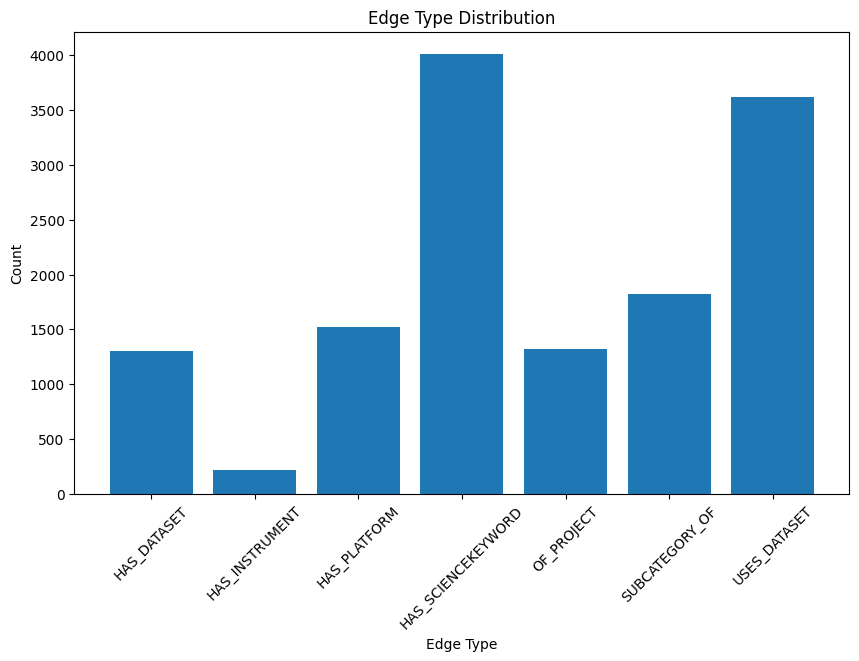


Edge Type Distribution:
OF_PROJECT: 1325 edges
HAS_DATASET: 1300 edges
HAS_SCIENCEKEYWORD: 4015 edges
USES_DATASET: 3623 edges
HAS_PLATFORM: 1519 edges
SUBCATEGORY_OF: 1823 edges
HAS_INSTRUMENT: 215 edges


In [16]:
edge_types = data.edge_attr.numpy()
edge_type_dist = Counter(edge_types)

plt.figure(figsize=(10, 6))
plt.bar(edge_type_dist.keys(), edge_type_dist.values())
plt.title('Edge Type Distribution')
plt.xlabel('Edge Type')
plt.ylabel('Count')
plt.xticks(range(len(relationship_mapping)), list(relationship_mapping.values()), rotation=45)
plt.show()

print("\nEdge Type Distribution:")
for edge_type, count in edge_type_dist.items():
    print(f"{relationship_mapping[edge_type]}: {count} edges")

### GCN Embedding generation and LInkprediction class
1. Node embeddings(vector representaion of each node)
2. predictions about which nodes should be connected


Step 1
1. Stack 2 GCN layers
2. Encode to generate node embeddings
3. call link prediction to make predictions
4. Two ways to compute the scoring: 
    use a simple MLP(two layer) with a sigmoid head to generete prediction probabilities, this is the default \
    or use a simple dot product to compute scores

In [17]:
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GCNLinkPrediction, self).__init__()
        
        # Store dimensions
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Create list of GCN layers
        self.convs = nn.ModuleList()
        
        # First layer maps from input features to hidden features
        self.convs.append(GCNConv(in_channels, hidden_channels))
        
        # Middle layers (if any)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        # Last layer maps to output embedding dimensions
        self.convs.append(GCNConv(hidden_channels, out_channels))
        
        # Link prediction scoring function (inner product)
        self.link_predictor = LinkPredictor(out_channels)
        
    def encode(self, x, edge_index):
        """Generate node embeddings"""
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Last layer (no ReLU to allow negative values in embeddings)
        x = self.convs[-1](x, edge_index)
        return x
    
    def decode(self, z, edge_index):
        """Predict link scores from embeddings"""
        return self.link_predictor(z, edge_index)
    
    def forward(self, x, edge_index, edge_label_index=None):
        """Forward pass: Generate embeddings and predict links"""
        # Generate node embeddings
        z = self.encode(x, edge_index)
        
        # If edge_label_index is provided, predict those links
        # Otherwise predict the links in edge_index
        edge_index_to_predict = edge_label_index if edge_label_index is not None else edge_index
        
        # Predict links
        return self.decode(z, edge_index_to_predict), z
    
class LinkPredictor(torch.nn.Module):
    """Link prediction layer that computes edge scores"""
    def __init__(self, embedding_dim, hidden_dim=None):
        super(LinkPredictor, self).__init__()
        if hidden_dim is not None:
            # MLP version for more complex link prediction
            self.lin1 = nn.Linear(embedding_dim * 2, hidden_dim)
            self.lin2 = nn.Linear(hidden_dim, 1)
            self.use_mlp = True
        else:
            # Simple dot product version
            self.use_mlp = False
    
    def forward(self, z, edge_index):
        # Extract node embeddings for each edge
        src, dst = edge_index
        
        if self.use_mlp:
            # Concatenate source and destination embeddings
            edge_features = torch.cat([z[src], z[dst]], dim=1)
            # Apply MLP
            x = self.lin1(edge_features)
            x = F.relu(x)
            x = self.lin2(x)
            return torch.sigmoid(x).squeeze()
        else:
            # Simple dot product scoring
            # Compute similarity between source and destination embeddings
            return torch.sum(z[src] * z[dst], dim=1)

## Training Function
1. Train in Batches for efficiency
2. Create negative samples(contrastive learning) this will be labeled as zero and the true classes labeled as one
3. Adam optimizer is preferred
4. use binary cross entropy for loss


In [18]:
def train_link_prediction(model, data, optimizer, batch_size=1024):
    model.train()
    
    # Get total number of edges
    total_edges = data.edge_index.size(1)
    
    # Process in batches for memory efficiency
    total_loss = 0
    
    for batch_start in range(0, total_edges, batch_size):
        # Get batch of positive edges
        batch_end = min(batch_start + batch_size, total_edges)
        edge_id = torch.arange(batch_start, batch_end)
        
        # Generate negative edges for this batch
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=batch_end - batch_start
        )
        
        # Create labels: 1 for positive edges, 0 for negative edges
        pos_labels = torch.ones(batch_end - batch_start, device=data.edge_index.device)
        neg_labels = torch.zeros(batch_end - batch_start, device=data.edge_index.device)
        labels = torch.cat([pos_labels, neg_labels])
        
        # Get predictions for both positive and negative edges
        pos_edge = data.edge_index[:, edge_id]
        edge_index_pred = torch.cat([pos_edge, neg_edge_index], dim=1)
        
        # Forward pass
        optimizer.zero_grad()
        pred, _ = model(data.x, data.edge_index, edge_index_pred)
        
        # Calculate loss
        loss = F.binary_cross_entropy_with_logits(pred, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss

### Evaluation Function
1. Generate negative edges
2. collect the positive edges as stored in the data object
3. make predictions on both negative and positive edges i.e evaluate on both edges
4. Calculate the AUC and average precision scores

In [19]:


# Evaluation function
@torch.no_grad()
def test_link_prediction(model, data, pos_edge_index, neg_edge_index=None):
    model.eval()
    
    # Get embeddings
    z = model.encode(data.x, data.edge_index)
    
    # Evaluate on positive edges
    pos_pred = model.decode(z, pos_edge_index)
    
    # If negative edges are not provided, generate them
    if neg_edge_index is None:
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        )
    
    # Evaluate on negative edges
    neg_pred = model.decode(z, neg_edge_index)
    
    # Create labels: 1 for positive edges, 0 for negative edges
    pos_labels = torch.ones(pos_pred.size(0), device=pos_pred.device)
    neg_labels = torch.zeros(neg_pred.size(0), device=neg_pred.device)
    
    # Concatenate predictions and labels
    pred = torch.cat([pos_pred, neg_pred])
    labels = torch.cat([pos_labels, neg_labels])
    
    # Calculate metrics
    pred_np = pred.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    auc = roc_auc_score(labels_np, pred_np)
    ap = average_precision_score(labels_np, pred_np)
    
    return auc, ap





### Call Train and Evaluation functions

1. call both the train and evaluation functions
2. Create a model specifying hidden and output layers(this will define the final dimension of embeddings)
3. choose an adam optimizer
4. train the model and evaluate on the validation data
5. track and save the best model 
6. Load the best model and test on the test_edges

In [20]:


def train_and_evaluate_model(data, in_channels, epochs=100):
    # Define model parameters
    hidden_channels = 64
    out_channels = 32  # Final embedding dimension
    
    # Create model
    model = GCNLinkPrediction(
        in_channels=in_channels, 
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=2,
        dropout=0.5
    )
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # Training loop
    best_val_auc = 0
    for epoch in range(1, epochs + 1):
        # Train
        loss = train_link_prediction(model, data, optimizer)
        
        # Evaluate
        val_auc, val_ap = test_link_prediction(model, data, data.val_edge_index)
        
        # Track best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_gcn_model.pt')
        
        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_gcn_model.pt'))
    
    # Evaluate on test set
    test_auc, test_ap = test_link_prediction(model, data, data.test_edge_index)
    print(f'Final Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')
    
    return model


Train and Evaluate

In [21]:

# Move data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Train model
in_channels = data.x.size(1)  # Number of input features
model = train_and_evaluate_model(data, in_channels, epochs=100)

# Get node embeddings
with torch.no_grad():
    node_embeddings = model.encode(data.x, data.edge_index).cpu().numpy()

# Save embeddings for further analysis
import numpy as np
np.save('node_embeddings.npy', node_embeddings)

print(f"Embeddings shape: {node_embeddings.shape}")
print("Node embeddings saved to 'node_embeddings.npy'")


Epoch: 010, Loss: 6.5358, Val AUC: 0.9865, Val AP: 0.9894
Epoch: 020, Loss: 6.4382, Val AUC: 0.9943, Val AP: 0.9949
Epoch: 030, Loss: 6.4461, Val AUC: 0.9949, Val AP: 0.9890
Epoch: 040, Loss: 6.4252, Val AUC: 0.9898, Val AP: 0.9872
Epoch: 050, Loss: 6.3962, Val AUC: 0.9934, Val AP: 0.9935
Epoch: 060, Loss: 6.3889, Val AUC: 0.9953, Val AP: 0.9963
Epoch: 070, Loss: 6.3140, Val AUC: 0.9896, Val AP: 0.9896
Epoch: 080, Loss: 6.3414, Val AUC: 0.9913, Val AP: 0.9926
Epoch: 090, Loss: 6.5186, Val AUC: 0.9940, Val AP: 0.9933
Epoch: 100, Loss: 6.3673, Val AUC: 0.9949, Val AP: 0.9958
Final Test AUC: 0.9963, Test AP: 0.9961
Embeddings shape: (5763, 32)
Node embeddings saved to 'node_embeddings.npy'


# Summary 
In each training iteration:

The GCN generates embeddings from node features and edges.

Positive and negative edges are encoded as pairs of node embeddings.

The model outputs a probability (0 to 1) indicating whether an edge exists.

Binary cross-entropy loss is computed using true labels (1 for real, 0 for fake).

We perform backpropagation to update weights in both the GCN and the MLP.


## Part 2

In [22]:
# make sure we have the right data
nodes_file = pd.read_csv("Dataset/nodes.csv")
train_edges_file = pd.read_csv("Dataset/train_edges.csv")
valid_file = pd.read_csv("Dataset/val_links.csv")
test_file = pd.read_csv("Dataset/test_links.csv")

In [23]:
print(f"{nodes_file.head()}\n\ntrain Edges\n\n {train_edges_file.head()}\n\nValidation edges\n\n {valid_file.head()}\n\ntest Edges\n\n {test_file.head()}")

   id        label                                         properties
0   0  ['Dataset']  {'abstract': 'The Atmospheric Infrared Sounder...
1   1  ['Dataset']  {'abstract': 'Version 07 is the current versio...
2   2  ['Dataset']  {'abstract': 'The Solar Backscattered Ultravio...
3   3  ['Dataset']  {'abstract': 'The data presented in this level...
4   4  ['Dataset']  {'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...

train Edges

    source  target   relationship_type
0    1152    1354          OF_PROJECT
1    1317    1164         HAS_DATASET
2    1317     768         HAS_DATASET
3    1271   23795  HAS_SCIENCEKEYWORD
4     820   23837  HAS_SCIENCEKEYWORD

Validation edges

    source  target
0    1144   23689
1    1016   23689
2    1298   24881
3     348   23780
4     876   23715

test Edges

    source  target
0     545   24190
1     867   24623
2     962   23690
3     857   23715
4     242   23819


## First we Create a networkx representation of the graph

In [24]:
def prepare_networkx_graph(nodes_df, edges_df):
    """
    Create a NetworkX graph from dataframes
    
    Parameters:
    -----------
    nodes_df : pandas.DataFrame
        DataFrame containing node information
    edges_df : pandas.DataFrame
        DataFrame containing edge information
        
    Returns:
    --------
    G : networkx.Graph
        NetworkX graph representation
    """
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in nodes_df.iterrows():
        G.add_node(row['id'], label=row['label'], properties=row['properties'])
    
    # Add edges with attributes (if available)
    if 'relationship_type' in edges_df.columns:
        for _, row in edges_df.iterrows():
            G.add_edge(row['source'], row['target'], relationship=row['relationship_type'])
    else:
        for _, row in edges_df.iterrows():
            G.add_edge(row['source'], row['target'])
    
    return G

In [25]:
G = prepare_networkx_graph(nodes_file, train_edges_file) 
print(G)

DiGraph with 5763 nodes and 13820 edges


 ** DiGraph with 5763 nodes and 13820 edges ** This is consistent with the pyg graph representation

### Next we generate negative samples for training

In [26]:
def generate_negative_samples_nx(G, num_samples, exclude_edges=None):
    """
    Generate negative samples (node pairs that are not connected)
    
    Parameters:
    -----------
    G : networkx.Graph
        Input graph
    num_samples : int
        Number of negative samples to generate
    exclude_edges : list of tuples
        List of edges to exclude from sampling
        
    Returns:
    --------
    neg_edges : list of tuples
        List of negative edge samples
    """
    if exclude_edges is None:
        exclude_edges = []
    
    # Create a set of existing edges for faster lookup
    existing_edges = set(G.edges())
    exclude_set = set(exclude_edges)
    
    # Get list of nodes
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    
    neg_edges = []
    attempts = 0
    max_attempts = num_samples * 10  # Limit attempts to avoid infinite loops
    
    while len(neg_edges) < num_samples and attempts < max_attempts:
        # Sample random node pair
        source = random.choice(nodes)
        target = random.choice(nodes)
        
        # Skip if self-loop or existing edge
        if source != target and (source, target) not in existing_edges and (source, target) not in exclude_set:
            neg_edges.append((source, target))
            
        attempts += 1
    
    return neg_edges

In [27]:
train_edges_file.shape

(13820, 3)

In [28]:
num_samples = train_edges_file.shape[0]
neg_edges = generate_negative_samples_nx(G, num_samples)
neg_edges

[(21076, 20339),
 (24283, 12500),
 (24784, 10713),
 (1417, 24443),
 (24011, 23495),
 (14438, 17618),
 (238, 23983),
 (2375, 271),
 (24882, 10917),
 (2696, 9008),
 (21009, 19646),
 (22260, 24487),
 (1374, 21138),
 (23723, 23818),
 (19774, 12409),
 (15103, 5613),
 (1359, 22121),
 (12973, 24519),
 (21836, 23636),
 (591, 729),
 (24921, 9417),
 (1532, 24430),
 (3632, 4810),
 (23978, 334),
 (413, 12564),
 (3287, 13266),
 (23423, 18357),
 (24758, 1291),
 (24627, 23615),
 (21572, 23193),
 (9601, 24449),
 (2045, 4636),
 (19157, 22173),
 (11862, 11974),
 (13270, 18797),
 (12425, 2614),
 (23647, 23495),
 (896, 704),
 (1693, 17618),
 (559, 17143),
 (21453, 24279),
 (18856, 1521),
 (1095, 23596),
 (23768, 419),
 (24103, 1347),
 (15210, 340),
 (2478, 52),
 (851, 23733),
 (13784, 1759),
 (16403, 11564),
 (21419, 9701),
 (24741, 24272),
 (17900, 22859),
 (1346, 5496),
 (16589, 1401),
 (23833, 1291),
 (24759, 4066),
 (23785, 800),
 (16614, 24548),
 (359, 645),
 (596, 822),
 (13446, 23713),
 (484, 3722)

 For each node, multiple walks are performed with a restart probability, capturing structural proximity to other nodes. These visit statistics are normalized to generate proximity scores, which we use to rank potential link pairs. 
 
 
 Randomwalk algorithm code is kept  in a separate file for readability

In [29]:

def run_random_walk_link_prediction(nodes_df, train_edges_df, valid_df, test_df):
    # Create full graph from training edges
    G = prepare_networkx_graph(nodes_df, train_edges_df)
    
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Convert to list of tuples
    val_edges = list(zip(valid_df['source'], valid_df['target']))
    test_edges = list(zip(test_df['source'], test_df['target']))
    
    # Generate negative samples for validation and testing
    val_neg_edges = generate_negative_samples_nx(G, len(val_edges), exclude_edges=val_edges+test_edges)
    test_neg_edges = generate_negative_samples_nx(G, len(test_edges), exclude_edges=val_edges+test_edges)
    
    # Initialize and run random walk model
    print("Initializing random walk model...")
    rw_model = RandomWalkLinkPrediction(G, num_walks=10, walk_length=80, restart_prob=0.2)
    
    print("Performing random walks...")
    rw_model.perform_walks()
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    val_auc, val_ap = rw_model.evaluate(val_edges, val_neg_edges)
    print(f"Validation results - AUC: {val_auc:.4f}, AP: {val_ap:.4f}")
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_auc, test_ap = rw_model.evaluate(test_edges, test_neg_edges)
    print(f"Test results - AUC: {test_auc:.4f}, AP: {test_ap:.4f}")

    return rw_model, G

In [30]:
rw_model, G = run_random_walk_link_prediction(nodes_file, train_edges_file, valid_file, test_file)

Graph built with 5763 nodes and 13820 edges
Initializing random walk model...
Performing random walks...
Evaluating on validation set...
Validation results - AUC: 0.6859, AP: 0.6819
Evaluating on test set...
Test results - AUC: 0.6874, AP: 0.6786


#obviously, this perfermance is far below that of the embeddings approach, it was expected 

### perform hyperparameter Tuning to try and improve performance

In [31]:
# Convert to list of tuples
val_edges = list(zip(valid_file['source'], valid_file['target']))
test_edges = list(zip(test_file['source'], test_file['target']))

# Generate negative samples for validation and testing
val_neg_edges = generate_negative_samples_nx(G, len(val_edges), exclude_edges=val_edges+test_edges)
test_neg_edges = generate_negative_samples_nx(G, len(test_edges), exclude_edges=val_edges+test_edges)

In [32]:
# Parameter tuning function
def tune_random_walk_parameters(G, val_edges, val_neg_edges):
    """
    Tune random walk parameters
    
    function Parameters:
    -----------
    G : networkx.Graph
        Training graph
    val_edges : list of tuples
        Validation positive edges  
    val_neg_edges : list of tuples
        Validation negative edges
        
    Returns: hyperparameters
    --------
    best_params : dict
        Best parameters found
    best_score : float
        Best validation AUC score
    """
    # Parameter grid
    param_grid = {
        'num_walks': [5, 10, 20],
        'walk_length': [40, 80, 120],
        'restart_prob': [0.0, 0.1, 0.2, 0.3]
    }
    
    best_score = 0.0
    best_params = {}
    
    # Try all combinations
    for num_walks in param_grid['num_walks']:
        for walk_length in param_grid['walk_length']:
            for restart_prob in param_grid['restart_prob']:
                print(f"Testing parameters: walks={num_walks}, length={walk_length}, restart={restart_prob}")
                
                # Create and train model
                model = RandomWalkLinkPrediction(G, num_walks=num_walks, 
                                              walk_length=walk_length, 
                                              restart_prob=restart_prob)
                model.perform_walks()
                
                # Evaluate
                val_auc, val_ap = model.evaluate(val_edges, val_neg_edges)
                print(f"Validation AUC: {val_auc:.4f}, AP: {val_ap:.4f}")
                
                # Track best parameters
                if val_auc > best_score:
                    best_score = val_auc
                    best_params = {
                        'num_walks': num_walks,
                        'walk_length': walk_length,
                        'restart_prob': restart_prob
                    }
    
    print(f"Best parameters found: {best_params} with AUC: {best_score:.4f}")
    return best_params, best_score

In [33]:
best_params, best_score = tune_random_walk_parameters(G, val_edges, val_neg_edges)

Testing parameters: walks=5, length=40, restart=0.0
Validation AUC: 0.6145, AP: 0.6097
Testing parameters: walks=5, length=40, restart=0.1
Validation AUC: 0.5954, AP: 0.5928
Testing parameters: walks=5, length=40, restart=0.2
Validation AUC: 0.5991, AP: 0.5959
Testing parameters: walks=5, length=40, restart=0.3
Validation AUC: 0.5929, AP: 0.5879
Testing parameters: walks=5, length=80, restart=0.0
Validation AUC: 0.6512, AP: 0.6441
Testing parameters: walks=5, length=80, restart=0.1
Validation AUC: 0.6533, AP: 0.6497
Testing parameters: walks=5, length=80, restart=0.2
Validation AUC: 0.6497, AP: 0.6458
Testing parameters: walks=5, length=80, restart=0.3
Validation AUC: 0.6329, AP: 0.6320
Testing parameters: walks=5, length=120, restart=0.0
Validation AUC: 0.6757, AP: 0.6715
Testing parameters: walks=5, length=120, restart=0.1
Validation AUC: 0.6643, AP: 0.6584
Testing parameters: walks=5, length=120, restart=0.2
Validation AUC: 0.6695, AP: 0.6654
Testing parameters: walks=5, length=120,

Create model with best params and test on test set

In [34]:
best_params #best params to be unpacked for Randomwalk algorithm

{'num_walks': 20, 'walk_length': 120, 'restart_prob': 0.2}

In [35]:
# Evaluate on test set with found new params
rw_model = RandomWalkLinkPrediction(G,**best_params)
print("Evaluating on test set...")
test_auc, test_ap = rw_model.evaluate(test_edges, test_neg_edges)
print(f"Test results - AUC: {test_auc:.4f}, AP: {test_ap:.4f}")

Evaluating on test set...
Test results - AUC: 0.7103, AP: 0.7163


- We evaluate both methods using:

- ROC-AUC: Measures the model's ability to distinguish positive and negative edges.

- Average Precision (AP): Evaluates precision across different recall levels, especially useful for imbalanced datasets.

## **4. Evaluation**

| Model               | ROC-AUC (Eval) | ROC-AUC (Test) | Average Precision (Eval) | Average Precision (Test) |
|--------------------|----------------|----------------|---------------------------|---------------------------|
| GCN + MLP          | 0.9949         | 0.9963         | 0.9958                    | 0.9961                    |
| Random Walk (No tuning) | 0.6859         | 0.6874         | 0.6819                    | 0.6786                    |
| Random Walk (Tuned) | 0.7051         | 0.7103         | 0.7018                    | 0.7163                    |

the GCN significantly outperforms Random Walk after training, achieving close to perfect ROC-AUC and AP scores. Random Walk, while simpler, shows improvement after hyperparameter tuning but still lags behind GCN in predictive performance.

# Conclusion

### This project really tested my patience 😂 but I learned a lot

**The following links contain all the tutorial I used to get started on PyG, learn link prediction and node predictions** \
## **References**: 
https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html \
https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html: 

**Thank you to Professor Aarmin(professor for advanced ML (Graphs ML) )   And all the LLMS that assisted me to write more optimised functions**